In [28]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.collections import PatchCollection
from matplotlib import cm

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy import stats
 
from matplotlib.lines import Line2D
from collections import defaultdict


def load_topic_word_distributions(taxa_prob):
    topic_word_prob_dict = defaultdict(lambda: defaultdict(float))
    topic_sum_dict = defaultdict(float)
    with open(taxa_prob,'r') as f:       
        for _line in f:        
            t, w, p = _line.split('\t')
            topic_word_prob_dict[t][w] = float(p)
            topic_sum_dict[t] += float(p)

    topic_word_probability_dict = defaultdict(lambda: defaultdict(float))
    for t, wp_dict in topic_word_prob_dict.items():
        for i, j in wp_dict.items():
            topic_word_probability_dict[int(t)][i] = j / topic_sum_dict[t]
    return topic_word_probability_dict
  

def get_df(tax_level, thrs):
    list_taxonomies = df_gen0_gen1_mb.columns[2:9]
    temp = df_gen0_gen1_mb.groupby([tax_level]).agg(np.sum)
    X = temp.T
    X = X.loc[:, (X != 0).any(axis=0)]
    X = np.round(X.div(X.sum(axis=1), axis=0)*100000).astype(int)
    pot_names = X.index
    
    if (tax_level != 'Phylum' or tax_level != 'Sequence'):
        abc = df_gen0_gen1_mb[df_gen0_gen1_mb[tax_level].isnull()]
        new_names = []
        if (tax_level == 'Class'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]))
        if (tax_level == 'Order'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]))
        if (tax_level == 'Family'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]))
        if (tax_level == 'Genus'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Family')]))
        if (tax_level == 'Species'):        
            for i in range(abc.shape[0]):
                new_names.append(str(abc.iloc[i, abc.columns.get_loc('Phylum')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Class')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Order')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Family')]) + str('_') + str(abc.iloc[i, abc.columns.get_loc('Genus')]))
          
        
        abc[tax_level] = new_names
        abc.index = abc[tax_level]
        del abc[tax_level]
        abc = abc.groupby([tax_level]).agg(np.sum)

        new_names = []
        for i in range(abc.shape[0]):
            new_names.append(abc.index[i] + str('_NA') + str(i+1))
        abc[tax_level] = new_names
        abc.index = abc[tax_level]
        del abc[tax_level]
        abc = abc.T

        X = pd.concat([X, abc], axis = 1)
        X = X.reindex(sorted(X.columns), axis=1)

    
    X = X.T
    excl_all = X[X.astype(bool).sum(axis=1) < thrs].index
    X = X.T

    X.drop(excl_all, axis=1, inplace=True)
    return X

def spearmanr_topic_vs_trait_holmbonf(cur_response, ntopics, alpha, m):
    res_df = pd.concat([pd.DataFrame(sub_data), pd.DataFrame(df_gen0_gen1["SoilSource"]).reset_index(), pd.DataFrame(df_gen0_gen1["Watering"]).reset_index(), pd.DataFrame(df_gen0_gen1["WateringStability"]).reset_index(), pd.DataFrame(df_gen0_gen1[cur_response]).reset_index()], axis = 1)
    del res_df['ID']
    res_df = pd.concat([res_df, pd.DataFrame(df_gen0_gen1["Generation"]).reset_index()], axis = 1)
    res_df = res_df[res_df[cur_response].notna()]
    res_df.columns = topic_names + ['SoilSource', 'Watering', 'WateringStability', cur_response, 'ID', 'Generation']
    store_pval = []
    store_cor = []
    for i in range(ntopics):
        temp = 'Topic ' + str(i+1)
        temp_sp = stats.spearmanr(res_df[cur_response], res_df[temp])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval


In [2]:
#read data from GEN 0-1
df_gen0_mb = pd.read_csv("data/MASTER_NDGen0_SoilBacteria.csv")
df_gen1_mb = pd.read_csv("data/MASTER_NDGen1_SoilBacteria.csv")
print('gen0 #mb ', df_gen0_mb.shape, " gen1 #mb ", df_gen1_mb.shape)

df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df = df_gen0_gen1_mb

# how many unidentified
print("Species: ", (len(df)-df.iloc[:,7].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,7].count())/len(df)*100, "% NAs")
print("Genus: ", (len(df)-df.iloc[:,6].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,6].count())/len(df)*100, "% NAs")
print("Family: ", (len(df)-df.iloc[:,5].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,5].count())/len(df)*100, "% NAs")
print("Order: ", (len(df)-df.iloc[:,4].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,4].count())/len(df)*100, "% NAs")
print("Class: ", (len(df)-df.iloc[:,3].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,3].count())/len(df)*100, "% NAs")
print("Phylum: ", (len(df)-df.iloc[:,2].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,2].count())/len(df)*100, "% NAs")
print("Kingdom: ", (len(df)-df.iloc[:,1].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,1].count())/len(df)*100, "% NAs")
print("DNA: ", (len(df)-df.iloc[:,0].count()), "NAs out of", len(df), " ", (len(df)-df.iloc[:,0].count())/len(df)*100, "% NAs")

print('\n')
print("Species: ", df.iloc[:,7].nunique(), "unique names out of", df.iloc[:,7].count())
print("Genus: ", df.iloc[:,6].nunique(), "unique names out of", df.iloc[:,6].count())
print("Family: ", df.iloc[:,5].nunique(), "unique names out of", df.iloc[:,5].count())
print("Order: ", df.iloc[:,4].nunique(), "unique names out of", df.iloc[:,4].count())
print("Class: ", df.iloc[:,3].nunique(), "unique names out of", df.iloc[:,3].count())
print("Phylum: ", df.iloc[:,2].nunique(), "unique names out of", df.iloc[:,2].count())
print("Kingdom: ", df.iloc[:,1].nunique(), "unique names out of", df.iloc[:,1].count())
print("DNA: ", df.iloc[:,0].nunique(), "unique names out of", df.iloc[:,0].count())

#aggregation
df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['ASV_number', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df_gen0_gen1_mb = df_gen0_gen1_mb.groupby(['Phylum']).agg(np.sum)
df_gen0_gen1_mb = df_gen0_gen1_mb.T
df_gen0_gen1_mb_full = df_gen0_gen1_mb.copy()
df_gen0_gen1_mb = df_gen0_gen1_mb.drop(['N00030', 'N00050'])
#gen0-1 source, treatment
df_gen0_id = pd.ExcelFile("data/MASTER_NDGen0_CornID.xlsx")
df_gen0_id = df_gen0_id.parse('ID', header=0, index_col = 0)
df_gen0_id = pd.DataFrame(df_gen0_id)

df_gen1_id = pd.ExcelFile("data/MASTER_NDGen1_CornID.xlsx")
df_gen1_id = df_gen1_id.parse('ID', header=0, index_col = 0)
df_gen1_id = pd.DataFrame(df_gen1_id)
df_gen0_gen1_id = pd.concat([df_gen0_id, df_gen1_id], axis=0)

df_gen0_gen1 = pd.merge(df_gen0_gen1_mb, df_gen0_gen1_id, right_on='ID', left_index=True)

#create treatment_stable column; stable(same watering as in gen0), switched(switched watering)
#Treatment_Source isn't avail for gen0
df_gen0_gen1['Treatment_Source'].fillna('None', inplace=True) 
df_gen0_gen1['Treatment_Stable'] = np.nan
source_index = df_gen0_gen1.columns.get_loc('Treatment_Source')
stable_index = df_gen0_gen1.columns.get_loc('Treatment_Stable')
water_index = df_gen0_gen1.columns.get_loc('Treatment')

idx_water_stability_none = []
idx_water_stability_stable = []
idx_water_stability_switched = []
for i in range(df_gen0_gen1.shape[0]):
    if (df_gen0_gen1.iloc[i, source_index] == 'None'):
        idx_water_stability_none.append(i)
    elif (df_gen0_gen1.iloc[i, source_index] != 'None' and df_gen0_gen1.iloc[i, source_index] == df_gen0_gen1.iloc[i, water_index]):
        idx_water_stability_stable.append(i)
    else:
        idx_water_stability_switched.append(i)

df_gen0_gen1.iloc[idx_water_stability_none, stable_index] = 'None'
df_gen0_gen1.iloc[idx_water_stability_stable, stable_index] = 'Stable'
df_gen0_gen1.iloc[idx_water_stability_switched, stable_index] = 'Switched'


df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Microbiome_Parent', 'SoilSource')
df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Treatment_Stable', 'WateringStability')
df_gen0_gen1.columns = df_gen0_gen1.columns.str.replace('Treatment', 'Watering')
gen_index = df_gen0_gen1.columns.get_loc('Generation')
source_index = df_gen0_gen1.columns.get_loc('SoilSource')
stability_index = df_gen0_gen1.columns.get_loc('WateringStability')
water_index = df_gen0_gen1.columns.get_loc('Watering')


df_gen0_gen1.iloc[:, source_index] = pd.Categorical(df_gen0_gen1.iloc[:, source_index])
df_gen0_gen1.iloc[:, source_index] = df_gen0_gen1.iloc[:, source_index].cat.codes
df_gen0_gen1.iloc[:, water_index] = pd.Categorical(df_gen0_gen1.iloc[:, water_index])
df_gen0_gen1.iloc[:, water_index] = df_gen0_gen1.iloc[:, water_index].cat.codes
df_gen0_gen1.iloc[:, stability_index] = pd.Categorical(df_gen0_gen1.iloc[:, stability_index])
df_gen0_gen1.iloc[:, stability_index] = df_gen0_gen1.iloc[:, stability_index].cat.codes


df_gen0_gen1_mb = pd.merge(df_gen0_mb, df_gen1_mb, on=['ASV_number', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Sequence'], how='outer')
df_gen0_gen1_mb_full = df_gen0_gen1_mb.copy()
df_gen0_gen1_mb = df_gen0_gen1_mb.drop(['N00030', 'N00050'], axis=1)

#gen0-1 physical 
df_gen0_phys = pd.ExcelFile("data/MASTER_NDGen0_PlantPhys.xlsx")
df_gen0_phys = df_gen0_phys.parse('Data', header=0, index_col = 0)
df_gen0_phys = pd.DataFrame(df_gen0_phys)

df_gen1_phys = pd.ExcelFile("data/MASTER_NDGen1_PlantPhys.xlsx")
df_gen1_phys = df_gen1_phys.parse('Data', header=0, index_col = 0)
df_gen1_phys = pd.DataFrame(df_gen1_phys)
df_gen0_gen1_phys = pd.concat([df_gen0_phys, df_gen1_phys], axis=0)


del df_gen0_gen1_phys['SCP_End']
del df_gen0_gen1_phys['GasLeaf']
del df_gen0_gen1_phys['LiCor']
del df_gen0_gen1_phys['GasEx_Date']
del df_gen0_gen1_phys['Gs_rate']
del df_gen0_gen1_phys['VWC_rate']
del df_gen0_gen1_phys['Gs.VWC_slope']
del df_gen0_gen1_phys['AboveDry_g']

df_gen0_gen1 = pd.merge(df_gen0_gen1, df_gen0_gen1_phys, right_on='ID', left_index=True)

X_phylum = get_df('Phylum', 4)
df_gen0_gen1['LMA'] = df_gen0_gen1['LMA'].fillna(df_gen0_gen1['LMA']. mean())

selected_mb_indicies = []
for i in range(X_phylum.shape[1]):
    if X_phylum.iloc[:, i][X_phylum.iloc[:, i] != 0].count() >= 0*X_phylum.shape[0]:
        selected_mb_indicies.append(i)

norm_by_pot_X_phylum = X_phylum.div(X_phylum.sum(axis=1), axis = 0)
response_list = ['Amax', 'Cond',
       'WUEi', 'Height_cm', 'Stem_Diam',
       'RootDry_g', 'LWC', 'LMA', 'DroughtTime']

print("Spearman correlations between topic abundances and ", response_list)
#print("shapes: ", norm_by_pot_X_phylum.shape, df_gen0_gen1.shape)

def spearmanr_individual_vs_trait_holmbonf_ph(cur_response, alpha, m):
    store_pval = []
    store_cor = []
    for i in range(len(selected_mb_indicies)):
        temp_sp = stats.spearmanr(norm_by_pot_X_phylum.iloc[:, selected_mb_indicies[i]], df_gen0_gen1[cur_response])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval

store_cor = []
store_pval = []
for i in response_list:
    store_cor.append(spearmanr_individual_vs_trait_holmbonf_ph(i, 0.05, len(selected_mb_indicies)*len(response_list))[0])
    store_pval.append(spearmanr_individual_vs_trait_holmbonf_ph(i, 0.05, len(selected_mb_indicies)*len(response_list))[1])

print("-------------------------")
indiv_list = norm_by_pot_X_phylum.iloc[:, selected_mb_indicies].columns
store_pval = [item for sublist in store_pval for item in sublist]
store_cor = [item for sublist in store_cor for item in sublist]
store_names = [item for item in response_list for i in range(len(selected_mb_indicies))]
store_indivs = list(indiv_list)*len(response_list)
df_p = pd.DataFrame(
    {'individual': store_indivs,
     'response': store_names,   
     'correlation': store_cor,
     'p-value': store_pval
    })
cor_alpha = len(df_p.sort_values("p-value"))
alpha = 0.05
df_p = df_p.sort_values("p-value", ascending=True).reset_index()
save_ix = []
for i in range(len(df_p)):
    if (df_p['p-value'][i] <= alpha/cor_alpha):
        cor_alpha -= 1
        save_ix.append(df_p.index[i])

df_p = df_p.iloc[save_ix, 1:5]
print(df_p.to_latex(index=False))  
df_p.iloc[:, 0].value_counts()
df_p.iloc[:, 0].nunique()
df_gen0_gen1['LMA'] = df_gen0_gen1['LMA'].fillna(df_gen0_gen1['LMA']. mean())



X_seq = get_df('Sequence', 0)
df_norm = X_seq
col_names = []
for i in range(len(df_norm.columns)):
    col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
    str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
    str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
nontruncated_col_names = col_names
trim = 254
col_names = [z[:-trim] for z in col_names]
df_norm.columns = col_names
df_norm = df_norm.T
    
    
selected_mb_indicies = []
for i in range(X_seq.shape[1]):
    if X_seq.iloc[:, i][X_seq.iloc[:, i] != 0].count() >= 0*X_seq.shape[0]:
        selected_mb_indicies.append(i)

norm_by_pot_X_seq = X_seq.div(X_seq.sum(axis=1), axis = 0)
response_list = ['Amax', 'Cond',
       'WUEi', 'Height_cm', 'Stem_Diam',
       'RootDry_g', 'LWC', 'LMA', 'DroughtTime']



def spearmanr_individual_vs_trait_holmbonf_sq(cur_response, alpha, m):
    store_pval = []
    store_cor = []
    for i in range(len(selected_mb_indicies)):
        temp_sp = stats.spearmanr(norm_by_pot_X_seq.iloc[:, selected_mb_indicies[i]], df_gen0_gen1[cur_response])
        store_cor.append(temp_sp[0])
        store_pval.append(temp_sp[1])
    return store_cor, store_pval

store_cor = []
store_pval = []
for i in response_list:
    store_cor.append(spearmanr_individual_vs_trait_holmbonf_sq(i, 0.05, len(selected_mb_indicies)*len(response_list))[0])
    store_pval.append(spearmanr_individual_vs_trait_holmbonf_sq(i, 0.05, len(selected_mb_indicies)*len(response_list))[1])

print("-------------------------")
indiv_list = norm_by_pot_X_seq.iloc[:, selected_mb_indicies].columns
store_pval = [item for sublist in store_pval for item in sublist]
store_cor = [item for sublist in store_cor for item in sublist]
store_names = [item for item in response_list for i in range(len(selected_mb_indicies))]
store_indivs = list(indiv_list)*len(response_list)
df_p = pd.DataFrame(
    {'individual': store_indivs,
     'response': store_names,   
     'correlation': store_cor,
     'p-value': store_pval
    })
cor_alpha = len(df_p.sort_values("p-value"))
alpha = 0.05
df_p = df_p.sort_values("p-value", ascending=True).reset_index()
save_ix = []
for i in range(len(df_p)):
    if (df_p['p-value'][i] <= alpha/cor_alpha):
        cor_alpha -= 1
        save_ix.append(df_p.index[i])


df_p = df_p.iloc[save_ix, 1:5]
#print(df_p.to_latex(index=False))  
print("ASVs")
df_p
#df_p.iloc[:, 0].value_counts()
#df_p.iloc[:, 0].nunique()
#df_p.sort_values(by = ['correlation', 'individual'], axis=0, ascending=[True, True], inplace=False,
#               kind='quicksort', na_position='first', ignore_index=True, key=None)[0:30]

#rename ASVs
X_seq = get_df('Sequence', 0)
df_norm = X_seq
col_names = []
for i in range(len(df_norm.columns)):
    col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
    str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
    str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
    str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
nontruncated_col_names = col_names
trim = 254
col_names = [z[:-trim] for z in col_names]
df_norm.columns = col_names
df_norm = df_norm.T
X_seq = df_norm.T
X_seq.head()

gen0 #mb  (9707, 66)  gen1 #mb  (9707, 73)
Species:  9033 NAs out of 9707   93.05655712372514 % NAs
Genus:  4966 NAs out of 9707   51.158957453384154 % NAs
Family:  2090 NAs out of 9707   21.530854022870095 % NAs
Order:  872 NAs out of 9707   8.983207994230966 % NAs
Class:  169 NAs out of 9707   1.7410116410837542 % NAs
Phylum:  0 NAs out of 9707   0.0 % NAs
Kingdom:  0 NAs out of 9707   0.0 % NAs
DNA:  0 NAs out of 9707   0.0 % NAs


Species:  424 unique names out of 674
Genus:  536 unique names out of 4741
Family:  275 unique names out of 7617
Order:  200 unique names out of 8835
Class:  95 unique names out of 9538
Phylum:  38 unique names out of 9707
Kingdom:  2 unique names out of 9707
DNA:  9707 unique names out of 9707
Spearman correlations between topic abundances and  ['Amax', 'Cond', 'WUEi', 'Height_cm', 'Stem_Diam', 'RootDry_g', 'LWC', 'LMA', 'DroughtTime']
-------------------------
\begin{tabular}{llrr}
\toprule
       individual &    response &  correlation &      p-value \

Thermoplasmatota     3
Crenarchaeota        2
Gemmatimonadota      2
Verrucomicrobiota    2
Bdellovibrionota     2
Actinobacteriota     1
WPS-2                1
Elusimicrobiota      1
Sumerlaeota          1
Dependentiae         1
Deinococcota         1
Name: individual, dtype: int64

11

-------------------------
ASVs


individual   response  \
0    Bacteroidota__Bacteroidia__Sphingobacteriales_...  Height_cm   
1    Proteobacteria__Gammaproteobacteria__Burkholde...  Height_cm   
2    Proteobacteria__Gammaproteobacteria__Cellvibri...  Height_cm   
3    Planctomycetota__Planctomycetes__Gemmatales__G...  Height_cm   
4    Bacteroidota__Bacteroidia__Sphingobacteriales_...  Height_cm   
..                                                 ...        ...   
207  Proteobacteria__Alphaproteobacteria__Sphingomo...  Stem_Diam   
208  Proteobacteria__Gammaproteobacteria__Salinisph...  Height_cm   
209  Proteobacteria__Alphaproteobacteria__Acetobact...  Height_cm   
210             Bacteroidota__nan__nan__nan__nan__nan_        LMA   
211  Actinobacteriota__Actinobacteria__Pseudonocard...  RootDry_g   

     correlation       p-value  
0       0.767264  2.559071e-24  
1       0.735327  1.697101e-21  
2       0.729798  4.754105e-21  
3       0.714902  6.751725e-20  
4       0.708021  2.173802e-19  
..           ...           ...  
207    -0.426705  1.304234e-06  
208    -0.426522  1.319435e-06  
209     0.426168  1.349245e-06  
210    -0.425907  1.371670e-06  
211    -0.425575  1.400612e-06  

[212 rows x 4 columns]

Bacteroidota__Bacteroidia__Cytophagales__Microscillaceae__nan__nan  \
N00001                                                  0                    
N00010                                                  0                    
N00011                                                  0                    
N00012                                                  0                    
N00013                                                  0                    

        Bacteroidota__Bacteroidia__Cytophagales__Microscillaceae__Ohtaekwangia__nan  \
N00001                                                  0                             
N00010                                                  0                             
N00011                                                  0                             
N00012                                                  0                             
N00013                                                  0                             

        Actinobacteriota__Actinobacteria__Propionibacteriales__Propionibacteriaceae__Cutibacterium__acnes/avidum_  \
N00001                                                  0                                                           
N00010                                                  0                                                           
N00011                                                  0                                                           
N00012                                                  0                                                           
N00013                                                  0                                                           

        Actinobacteriota__Actinobacteria__Micrococcales__Intrasporangiaceae__Aquipuribacter__nan_  \
N00001                                                  0                                           
N00010                                                  0                                           
N00011                                                  0                                           
N00012                                                  0                                           
N00013                                                  0                                           

        Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_  \
N00001                                                  0                                          
N00010                                                  0                                          
N00011                                                  0                                          
N00012                                                  0                                          
N00013                                                  0                                          

        Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_  \
N00001                                                  0                                          
N00010                                                  0                                          
N00011                                                  0                                          
N00012                                                  0                                          
N00013                                                  0                                          

        Actinobacteriota__Actinobacteria__Micrococcales__Microbacteriaceae__Microbacterium__nan_  \
N00001                                                  0                                          
N00010                                                  0                                          
N00011                                                  0                                          
N00012                                                  0                                          
N000

In [8]:
#specify tax_level below
tax_level = 'Sequence'#'Phylum', 'Class', 'Order', 'Family', 'Sequence'
    
if (tax_level == 'Phylum'):
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 6
    thrs = 4
elif (tax_level == 'Class'):        
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 8
    thrs = 4        
elif (tax_level == 'Order'):        
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 10
    thrs = 4
elif (tax_level == 'Family'):
    folder_main_name = 'nonde_data/'
    folder_name = '_res'
    path = '../gitlab/data/' + str(folder_main_name) + str(tax_level) + str(folder_name)
    NTOPICS = 20
    thrs = 4  
elif (tax_level == 'Sequence'):
    folder_main_name = 'nonde_data/'
    folder_name = '_original_res10k'
    path = '../gitlab/data/5cv_all_sequence'
    NTOPICS = 25
    thrs = 0        

    

X = get_df(tax_level, thrs)
print("X.shape: ", X.shape)
df = X.iloc[:, 0:].div(X.iloc[:, 0:].sum(axis=1), axis=0)
df = pd.DataFrame(np.mean(df.iloc[:, :]))
df = df.sort_values(0, ascending = False)
df = df.T

# uncomment to produce files for MALLET
# for row_id in range(X.shape[0]):
#     ts = []
#     for col_id in range(X.shape[1]):
#         ts = str(ts) + (X.iloc[row_id, :].index[col_id] + ' ') * X.iloc[row_id, col_id]

#     textfile = open(str(str('../gitlab/data/nonde_data/sequence_less2/') + str(X.index[row_id]) + str('.txt')), 'w')
#     textfile.write(ts[2:])
#     textfile.close()
    
    
topic_names = []
for i in range(NTOPICS):
    topic_names.append('Topic ' + str(i+1))
    
list_taxa = X.columns
df_taxa = pd.DataFrame(list_taxa).T
df_taxa.columns = df_taxa.iloc[0, :]
twd = load_topic_word_distributions(path + '/topic-word-weights_'+str(NTOPICS)+'.dat')

temp = pd.DataFrame([twd[0]])
df_al = pd.merge(df_taxa.T, temp.T, left_index=True, right_index=True, how='inner').fillna(0)
del df_al[tax_level]
df_al = df_al.T
df_al.reset_index(inplace=True)
del df_al['index']
df_fin = df_al
for k in range(1, len(twd)):
    temp = pd.DataFrame([twd[k]])
    df_al = pd.merge(df_taxa.T, temp.T, left_index=True, right_index=True, how='inner').fillna(0)
    del df_al[tax_level]
    df_al = df_al.T
    df_al.reset_index(inplace=True)
    del df_al['index']
    df_fin = pd.merge(df_fin.T, df_al.T, left_index=True, right_index=True, how='inner').fillna(0) 
    df_fin = df_fin.T
    
df_norm = df_fin.T
df_norm.columns = topic_names
g = df_norm
aa = X.iloc[:, 0:].div(X.iloc[:, 0:].sum(axis=1), axis=0)
df = pd.DataFrame(np.mean(aa.iloc[:, :]))
df.index = np.sort(list_taxa)
s = g.T
df = df.T
s = s / df.loc[0]
s = s.T
s = s.div(s.sum())

if tax_level == 'Sequence':
    df_norm = df_norm.T
    col_names = []
    for i in range(len(df_norm.columns)):
        col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,])  + "__" +
        str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) + "__" + 
        str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(df_norm.columns[i])].iloc[0,]) ))
    nontruncated_col_names = col_names
    trim = 254 #change # of chars to trim ASV names
    col_names = [z[:-trim] for z in col_names]
    df_norm.columns = col_names
    df_norm = df_norm.T

    s = s.T
    col_names = []
    for i in range(len(s.columns)):
        col_names.append( str(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Family'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" +
        str(df_gen0_gen1_mb['Genus'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,])  + "__" +
        str(df_gen0_gen1_mb['Species'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) + "__" + 
        str(df_gen0_gen1_mb['Sequence'].loc[df_gen0_gen1_mb['Sequence'] == str(s.columns[i])].iloc[0,]) ))
    nontruncated_col_names = col_names
    trim = 254
    col_names = [z[:-trim] for z in col_names]
    s.columns = col_names
    s = s.T
    

if tax_level == 'Class':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Class'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Class'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext

if tax_level == 'Order':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Order'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext
    
if tax_level == 'Family':
    ylabels = df_norm.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" +
                               str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    df_norm.index = ylabels_ext
    ylabels = s.index
    ylabels_ext = []
    for i in range(0, len(ylabels)):
        if ylabels[i].find("_NA") == -1:
            ylabels_ext.append(str(df_gen0_gen1_mb['Phylum'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + 
                               str(df_gen0_gen1_mb['Class'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" +
                               str(df_gen0_gen1_mb['Order'].loc[df_gen0_gen1_mb['Family'] == str(ylabels[i])].iloc[0,]) + "_" + ylabels[i])
        else:
            ylabels_ext.append(str(ylabels[i]))
    s.index = ylabels_ext
    
twd = load_topic_word_distributions(path + '/topic-word-weights_'+str(NTOPICS)+'.dat')
temp = pd.DataFrame([twd[0]])
for i in range(1, len(twd)):
    temp = pd.concat([temp, pd.DataFrame([twd[i]])])
temp = temp.reset_index()
del temp['index']
mtx_topics = pd.DataFrame(cosine_similarity(temp))
matrix = np.triu(mtx_topics)

print("The # topic pairs that have cosine similarity >= 0.9 is", matrix[matrix >= 0.90].shape[0] - NTOPICS)
for i in range(NTOPICS-1):
    for j in range(i+1, NTOPICS):
        if (matrix[i][j] > 0.8):
            print(i+1, j+1, matrix[i][j])

X.shape:  (119, 3946)
The # topic pairs that have cosine similarity >= 0.9 is 0
9 13 0.8255953709583634
13 20 0.8136522370201485
16 23 0.8035811363559758


(58, 25)

[[<matplotlib.axis.XTick at 0x7fb08b951fd0>,
 [Text(0, 0, 'Topic 9'),
  Text(1, 0, 'Topic 13'),
  Text(2, 0, 'Topic 17'),
  Text(3, 0, 'Topic 5'),
  Text(4, 0, 'Topic 18'),
  Text(5, 0, 'Topic 12'),
  Text(6, 0, 'Topic 1'),
  Text(7, 0, 'Topic 3'),
  Text(8, 0, 'Topic 20'),
  Text(9, 0, 'Topic 24'),
  Text(10, 0, 'Topic 11'),
  Text(11, 0, 'Topic 10'),
  Text(12, 0, 'Topic 25'),
  Text(13, 0, 'Topic 8'),
  Text(14, 0, 'Topic 15'),
  Text(15, 0, 'Topic 7'),
  Text(16, 0, 'Topic 14'),
  Text(17, 0, 'Topic 22'),
  Text(18, 0, 'Topic 21'),
  Text(19, 0, 'Topic 16'),
  Text(20, 0, 'Topic 19'),
  Text(21, 0, 'Topic 23'),
  Text(22, 0, 'Topic 2'),
  Text(23, 0, 'Topic 6'),
  Text(24, 0, 'Topic 4')],
 [Text(0, 0, 'Actinobacteriota__Actinobacteria__Micrococcales__Micrococcaceae__Pseudarthrobacter__nan_'),
  Text(0, 1, 'Actinobacteriota__Actinobacteria__Streptomycetales__Streptomycetaceae__Streptomyces__nan_'),
  Text(0, 2, 'Bacteroidota__Bacteroidia__Chitinophagales__Chitinophagaceae__Niastella

[Text(0, 0, 'Topic 9'),
 Text(1, 0, 'Topic 13'),
 Text(2, 0, 'Topic 17'),
 Text(3, 0, 'Topic 5'),
 Text(4, 0, 'Topic 18'),
 Text(5, 0, 'Topic 12'),
 Text(6, 0, 'Topic 1'),
 Text(7, 0, 'Topic 3'),
 Text(8, 0, 'Topic 20'),
 Text(9, 0, 'Topic 24'),
 Text(10, 0, 'Topic 11'),
 Text(11, 0, 'Topic 10'),
 Text(12, 0, 'Topic 25'),
 Text(13, 0, 'Topic 8'),
 Text(14, 0, 'Topic 15'),
 Text(15, 0, 'Topic 7'),
 Text(16, 0, 'Topic 14'),
 Text(17, 0, 'Topic 22'),
 Text(18, 0, 'Topic 21'),
 Text(19, 0, 'Topic 16'),
 Text(20, 0, 'Topic 19'),
 Text(21, 0, 'Topic 23'),
 Text(22, 0, 'Topic 2'),
 Text(23, 0, 'Topic 6'),
 Text(24, 0, 'Topic 4')]

['red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'black',
 'black',
 'black',
 'black',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue']

[Text(0, 0, 'Actinobacteriota__Actinobacteria__Micrococcales__Micrococcaceae__Pseudarthrobacter__nan_'),
 Text(0, 1, 'Actinobacteriota__Actinobacteria__Streptomycetales__Streptomycetaceae__Streptomyces__nan_'),
 Text(0, 2, 'Bacteroidota__Bacteroidia__Chitinophagales__Chitinophagaceae__Niastella__vici_'),
 Text(0, 3, 'Bacteroidota__Bacteroidia__Cytophagales__Microscillaceae__nan__nan_'),
 Text(0, 4, 'Bacteroidota__Bacteroidia__Cytophagales__Spirosomaceae__Dyadobacter__endophyticus/fermentans_'),
 Text(0, 5, 'Bacteroidota__Bacteroidia__Cytophagales__Spirosomaceae__Dyadobacter__fermentans_'),
 Text(0, 6, 'Bacteroidota__Bacteroidia__Cytophagales__Spirosomaceae__Dyadobacter__nan_'),
 Text(0, 7, 'Bacteroidota__Bacteroidia__Flavobacteriales__Crocinitomicaceae__Fluviicola__nan_'),
 Text(0, 8, 'Bacteroidota__Bacteroidia__Sphingobacteriales__KD3-93__nan__nan_'),
 Text(0, 9, 'Bacteroidota__Bacteroidia__Sphingobacteriales__Sphingobacteriaceae__Pedobacter__nan_'),
 Text(0, 10, 'Bacteroidota__Bacter

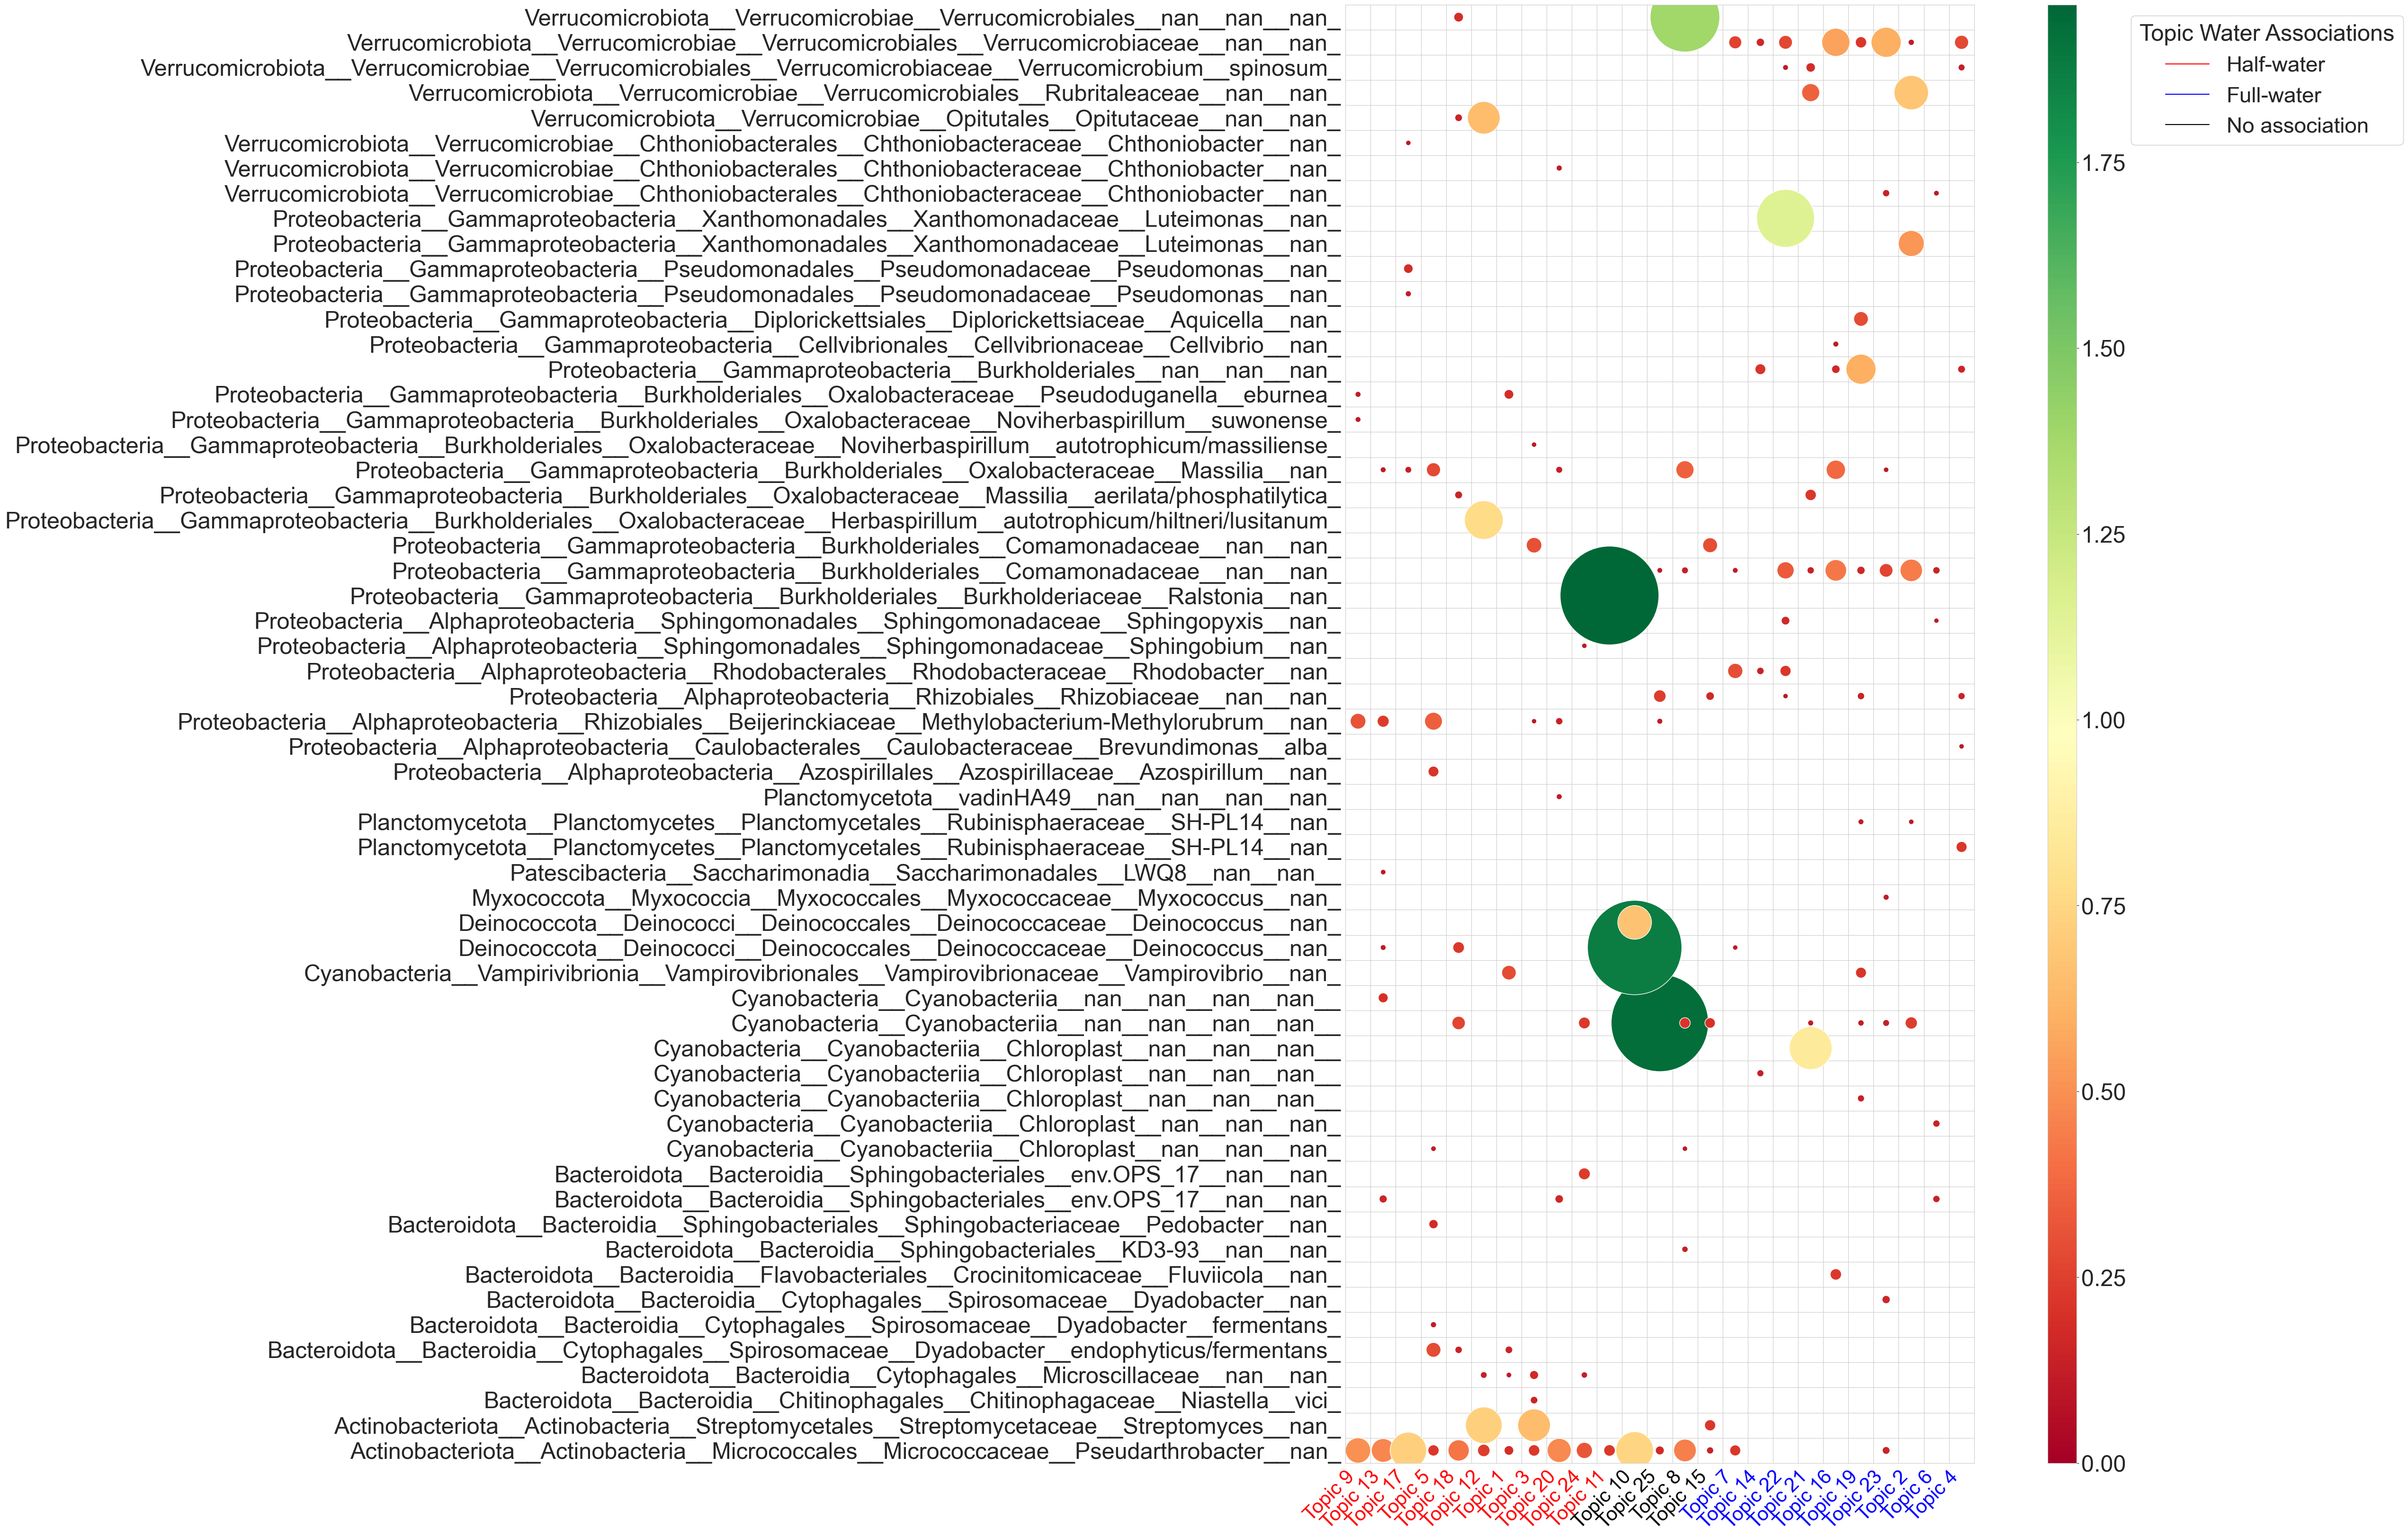

In [9]:
#bubble plots
if tax_level == "Sequence":
    g_thrs = 0.025#0.01#.025
    g = df_norm
    g = g[g >= g_thrs].fillna(0)
    g = g[(g.T != 0).any()]
    g = g.sort_index()
    g.shape
    #seqwater 
    g = g[['Topic 9', 'Topic 13', 'Topic 17', 'Topic 5', 'Topic 18', 'Topic 12', 'Topic 1', 'Topic 3', 'Topic 20', 'Topic 24', 'Topic 11', 'Topic 10', 'Topic 25', 'Topic 8', 'Topic 15', 'Topic 7', 'Topic 14', 'Topic 22', 'Topic 21', 'Topic 16', 'Topic 19', 'Topic 23', 'Topic 2', 'Topic 6', 'Topic 4']]
    #soil g = g[['Topic 1', 'Topic 4', 'Topic 15', 'Topic 24', 'Topic 3', 'Topic 12', 'Topic 19', 'Topic 9', 'Topic 14', 'Topic 20', 'Topic 6', 'Topic 13', 'Topic 21', 'Topic 11', 'Topic 17', 'Topic 23', 'Topic 7', 'Topic 18', 'Topic 5', 'Topic 2', 'Topic 8', 'Topic 16', 'Topic 10', 'Topic 22', 'Topic 25']]
    #seqstability g = g[['Topic 9', 'Topic 14', 'Topic 7', 'Topic 13', 'Topic 4', 'Topic 3', 'Topic 12', 'Topic 22', 'Topic 21', 'Topic 11', 'Topic 6', 'Topic 8', 'Topic 15', 'Topic 18', 'Topic 23', 'Topic 24', 'Topic 19', 'Topic 1', 'Topic 2', 'Topic 16', 'Topic 25', 'Topic 5', 'Topic 10', 'Topic 17', 'Topic 20']]

    ylabels = g.index
    xlabels = g.columns
    N = len(ylabels)
    M = len(xlabels)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    c = np.random.rand(N, M)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(40,40))

    R = g*4
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(np.array(R).flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=np.array(R).flatten(), cmap="RdYlGn")
    ax.add_collection(col)

    y_order = sorted(ylabels)
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=y_order)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation = 45, ha="right", fontsize=30)

    colors = [['red']*11, ['black']*4, ['blue']*10]
    colors = [item for sublist in colors for item in sublist]
    colors
    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)


    ax.set_yticklabels(y_order, fontsize=35)
    ax.grid(which='both')
    ax.set_aspect("equal", "box")
    cbar = plt.colorbar(col, aspect=50)
    cbar.ax.tick_params(labelsize=35) 

    legend_elements2 = [Line2D([0], [0], color = 'red', label='Half-water',
                              markerfacecolor='black', markersize=30),
                       Line2D([0], [0], color = 'blue', label='Full-water',
                              markerfacecolor='black', markersize=30),
                       Line2D([0], [0], color = 'black', label='No association',
                              markerfacecolor='black', markersize=30)]

    leg2 = ax.legend(handles=legend_elements2, loc = 'upper right', fontsize = 33, title_fontsize = 35, bbox_to_anchor = (1.7, 1), ncol = 1, title = 'Topic Water Associations')
    ax.add_artist(leg2)
    #plt.savefig('./upd_images/plot_water_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();
else:
    g_thrs = 0 # change this threshold for plotting, put 0 for phylum and class; 0.025 for Sequence (ASV)
    g = df_norm
    g = g[g >= g_thrs].fillna(0)
    g = g[(g.T != 0).any()]
    g = g.sort_index()
    g.shape
    #family level, order topics g = g[['Topic 8', 'Topic 3', 'Topic 1', 'Topic 12', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 19', 'Topic 15', 'Topic 5', 'Topic 6', 'Topic 16', 'Topic 4', 'Topic 2', 'Topic 17', 'Topic 7', 'Topic 20', 'Topic 18', 'Topic 13', 'Topic 14']]
    #ASV plot by water g = g[['Topic 9', 'Topic 13', 'Topic 17', 'Topic 5', 'Topic 18', 'Topic 12', 'Topic 1', 'Topic 3', 'Topic 20', 'Topic 24', 'Topic 11', 'Topic 10', 'Topic 25', 'Topic 8', 'Topic 15', 'Topic 7', 'Topic 14', 'Topic 22', 'Topic 21', 'Topic 16', 'Topic 19', 'Topic 23', 'Topic 2', 'Topic 6', 'Topic 4']]
    #ASV plot by soil g = g[['Topic 1', 'Topic 4', 'Topic 15', 'Topic 24', 'Topic 3', 'Topic 12', 'Topic 19', 'Topic 9', 'Topic 14', 'Topic 20', 'Topic 6', 'Topic 13', 'Topic 21', 'Topic 11', 'Topic 17', 'Topic 23', 'Topic 7', 'Topic 18', 'Topic 5', 'Topic 2', 'Topic 8', 'Topic 16', 'Topic 10', 'Topic 22', 'Topic 25']]

    ylabels = g.index
    xlabels = g.columns
    N = len(ylabels)
    M = len(xlabels)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    c = np.random.rand(N, M)
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(40,40))

    R = g #phylum, R=g*4 for ASV, control size of the bubbles
    circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(np.array(R).flat, x.flat, y.flat)]
    col = PatchCollection(circles, array=np.array(R).flatten(), cmap="RdYlGn")
    ax.add_collection(col)

    y_order = sorted(ylabels)
    ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=y_order)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.set_xticklabels(xlabels, rotation = 45, ha="right", fontsize=20)
    ax.set_yticklabels(y_order, fontsize=20)
    ax.grid(which='both')
    ax.set_aspect("equal", "box")
    cbar = plt.colorbar(col, aspect=50)
    cbar.ax.tick_params(labelsize=20)
    #plt.savefig('./upd_images/plot_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();



In [11]:
#produce tables in Supplementary; 
N = 5 #10
topdf = np.round(df_norm.mask(df_norm.rank(axis=0, method='min', ascending=False) > N, 0)*100, 3)
topdf = topdf.loc[~(topdf==0).all(axis=1)]
topdf
#top10df.to_csv(r'./csv_lda_files/top_5_most_probable_asvs_in_LDA_topics.csv', header=True, index=True, sep='\t')
#top10df.to_excel(r'./csv_lda_files/top_5_most_probable_asvs_in_LDA_topics.xlsx', header=True, index=True)
#print(top10df.to_latex(index=True)) 


N = 5 #10
topreldf = np.round(s.mask(s.rank(axis=0, method='min', ascending=False) > N, 0)*100, 3)
topreldf = topreldf.loc[~(topreldf==0).all(axis=1)]
topreldf
#top10df.to_excel(r'./csv_lda_files/top_5_most_amplified_asvs_in_LDA_topics.xlsx', header=True, index=True)
#print(top10df.to_latex(index=True)) 


Topic 1  Topic 2  Topic 3  \
Planctomycetota__Planctomycetes__Planctomycetal...    0.000    0.000    0.000   
Verrucomicrobiota__Verrucomicrobiae__Verrucomic...    0.000    0.000    0.000   
Verrucomicrobiota__Verrucomicrobiae__Chthonioba...    0.000    0.000    0.000   
Verrucomicrobiota__Verrucomicrobiae__Chthonioba...    0.000    0.000    0.000   
Verrucomicrobiota__Verrucomicrobiae__Chthonioba...    0.000    0.000    0.000   
Verrucomicrobiota__Verrucomicrobiae__Verrucomic...    0.000    2.998    0.000   
Verrucomicrobiota__Verrucomicrobiae__Verrucomic...    0.000   17.051    0.000   
Verrucomicrobiota__Verrucomicrobiae__Verrucomic...    0.000    0.000    0.000   
Cyanobacteria__Vampirivibrionia__Vampirovibrion...    7.156    0.000    0.000   
Cyanobacteria__Cyanobacteriia__Chloroplast__nan...    0.000    0.000    0.000   
Verrucomicrobiota__Verrucomicrobiae__Opitutales...    0.000    0.000    0.000   
Cyanobacteria__Cyanobacteriia__Chloroplast__nan...    0.000    0.000    0.000   
Deinococcota__Deinococci__Deinococcales__Deinoc...    0.000    0.000    0.000   
Deinococcota__Deinococci__Deinococcales__Deinoc...    0.000    0.000    0.000   
Cyanobacteria__Cyanobacteriia__nan__nan__nan__n...    0.000    5.987    0.000   
Proteobacteria__Gammaproteobacteria__Diploricke...    0.000    0.000    0.000   
Actinobacteriota__Actinobacteria__Streptomyceta...    0.000    0.000   16.197   
Actinobacteriota__Actinobacteria__Pseudonocardi...    0.000    0.000    0.000   
Actinobacteriota__Actinobacteria__Micrococcales...    4.691    0.000    5.593   
Bacteroidota__Bacteroidia__Cytophagales__Micros...    2.697    0.000    4.382   
Bacteroidota__Bacteroidia__Sphingobacteriales__...    0.000    0.000    0.000   
Bacteroidota__Bacteroidia__Chitinophagales__Chi...    0.000    0.000    3.678   
Bacteroidota__Bacteroidia__Sphingobacteriales__...    0.000    0.000    0.000   
Proteobacteria__Alphaproteobacteria__Sphingomon...    0.000    0.000    0.000   
Proteobacteria__Alphaproteobacteria__Sphingomon...    0.000    0.000    0.000   
Proteobacteria__Alphaproteobacteria__Rhodobacte...    0.000    0.000    0.000   
Proteobacteria__Alphaproteobacteria__Rhizobiale...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Pseudomona...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Pseudomona...    0.000    0.000    0.000   
Proteobacteria__Alphaproteobacteria__Rhizobiale...    0.000    0.000    0.000   
Proteobacteria__Alphaproteobacteria__Rhizobiale...    0.000    0.000    0.000   
Proteobacteria__Alphaproteobacteria__Azospirill...    0.000    0.000    0.000   
Bacteroidota__Bacteroidia__Flavobacteriales__Cr...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...    0.000    0.000    7.616   
Proteobacteria__Gammaproteobacteria__Burkholder...    0.000   11.072    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...    4.716    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Xanthomona...    0.000    0.000    0.000   
Proteobacteria__Gammaproteobacteria__Xanthomona...    0.000   12.859    0.000   
Bacteroidota__Bacteroidia__Cytophagales__Spiros...    3.690    0.000    0.000   
Bacteroidota__Bacteroidia__Cytophagales__Spiros...    0.000    0.000    0.000   
Cyanobacteria__Cyanobacteriia__nan__nan__nan__n...    0.000    0.000    0.000   
Cyanobacteria__Cyanobacteriia__Chloroplast__nan...    0.000    0.000    0.000   

                                                    Topic 4  Topic 5  Topic 6  \
P

Topic 1  Topic 2  Topic 3  \
Cyanobacteria__Cyanobacteriia__Cyanobacteriales...      0.0    0.000      0.0   
Proteobacteria__Gammaproteobacteria__Burkholder...      0.0    0.000      0.0   
Planctomycetota__Planctomycetes__Planctomycetal...      0.0    0.000      0.0   
Patescibacteria__Parcubacteria__Candidatus_Kais...      0.0    0.000      0.0   
Chloroflexi__Chloroflexia__Thermomicrobiales__J...      0.0    0.000      0.0   
...                                                     ...      ...      ...   
Cyanobacteria__Sericytochromatia__nan__nan__nan...      0.0    0.000      0.0   
Acidobacteriota__Acidobacteriae__Acidobacterial...      0.0    0.000      0.0   
Acidobacteriota__Acidobacteriae__Acidobacterial...      0.0    0.000      0.0   
Verrucomicrobiota__Chlamydiae__Chlamydiales__Si...      0.0    0.000      0.0   
Myxococcota__Polyangia__mle1-27__nan__nan__nan_         0.0    2.145      0.0   

                                                    Topic 4  Topic 5  Topic 6  \
Cyanobacteria__Cyanobacteriia__Cyanobacteriales...      0.0      0.0      0.0   
Proteobacteria__Gammaproteobacteria__Burkholder...      0.0      0.0      0.0   
Planctomycetota__Planctomycetes__Planctomycetal...      0.0      0.0      0.0   
Patescibacteria__Parcubacteria__Candidatus_Kais...      0.0      0.0      0.0   
Chloroflexi__Chloroflexia__Thermomicrobiales__J...      0.0      0.0      0.0   
...                                                     ...      ...      ...   
Cyanobacteria__Sericytochromatia__nan__nan__nan...      0.0      0.0      0.0   
Acidobacteriota__Acidobacteriae__Acidobacterial...      0.0      0.0      0.0   
Acidobacteriota__Acidobacteriae__Acidobacterial...      0.0      0.0      0.0   
Verrucomicrobiota__Chlamydiae__Chlamydiales__Si...      0.0      0.0      0.0   
Myxococcota__Polyangia__mle1-27__nan__nan__nan_         0.0      0.0      0.0   

                                                    Topic 7  Topic 8  Topic 9  \
Cyanobacteria__Cyanobacteriia__Cyanobacteriales...      0.0      0.0    0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...      0.0      0.0    0.000   
Planctomycetota__Planctomycetes__Planctomycetal...      0.0      0.0    0.000   
Patescibacteria__Parcubacteria__Candidatus_Kais...      0.0      0.0    0.000   
Chloroflexi__Chloroflexia__Thermomicrobiales__J...      0.0      0.0    0.000   
...                                                     ...      ...      ...   
Cyanobacteria__Sericytochromatia__nan__nan__nan...      0.0      0.0    0.000   
Acidobacteriota__Acidobacteriae__Acidobacterial...      0.0      0.0    0.000   
Acidobacteriota__Acidobacteriae__Acidobacterial...      0.0      0.0    0.486   
Verrucomicrobiota__Chlamydiae__Chlamydiales__Si...      0.0      0.0    0.000   
Myxococcota__Polyangia__mle1-27__nan__nan__nan_         0.0      0.0    0.000   

                                                    Topic 10  ...  Topic 16  \
Cyanobacteria__Cyanobacteriia__Cyanobacteriales...       0.0  ...     0.000   
Proteobacteria__Gammaproteobacteria__Burkholder...       0.0  ...     0.000   
Planctomycetota__Planctomycetes__Planctomycetal...       0.0  ...     1.594   
Patescibacteria__Parcubacteria__Candidatus_Kais...       0.0  ...     0.000   
Chloroflexi__Chloroflexia__Thermomicrobiales__J...       0.0  ...     1.586   
...                                                      ...  ...       ...   
Cyanobacteria__Sericytochromatia__nan__nan__nan...       0.0  ...     0.000   
Acidobacteriota__Acidobacteriae__Acidobacterial...       0.0  ...     0.000   
Acidobacteriota__Acidobacteriae__Acidobacterial...       0.0  ...     0.000   
Verrucomicrobiota__Chlamydiae__Chlamydiales__Si...       0.0  ...     0.000   
Myxococcota__Polyangia__mle1-27__nan__nan__nan_          0.0  ...     0.000   

                                                    Topic 17  Topic 18  \
Cyanobacteria__Cyanobacteriia__Cyanobacteriales...       0.0     3.556   
Proteobacteria__Gammaproteobacteria_

LDA probabilities
Topic 1
Cyanobacteria__Vampirivibrionia__Vampirovibrionales__Vampirovibrionaceae__Vampirovibrio__nan_        0.071564
Proteobacteria__Gammaproteobacteria__Burkholderiales__Oxalobacteraceae__Pseudoduganella__eburnea_    0.047159
Actinobacteriota__Actinobacteria__Micrococcales__Micrococcaceae__Pseudarthrobacter__nan_             0.046915
Bacteroidota__Bacteroidia__Cytophagales__Spirosomaceae__Dyadobacter__endophyticus/fermentans_        0.036897
Bacteroidota__Bacteroidia__Cytophagales__Microscillaceae__nan__nan_                                  0.026973
Proteobacteria__Gammaproteobacteria__Burkholderiales__Comamonadaceae__Ideonella__nan_                0.021160
Actinobacteriota__Actinobacteria__Streptomycetales__Streptomycetaceae__Streptomyces__nan_            0.020981
Proteobacteria__Alphaproteobacteria__Sphingomonadales__Sphingomonadaceae__Sphingobium__nan_          0.019702
Bacteroidota__Bacteroidia__Sphingobacteriales__env.OPS_17__nan__nan_                          

Text(0.5, 0, 'Number of most probable taxa in topics')

Text(0, 0.5, 'Probability')

Text(0.5, 1.0, ' ')

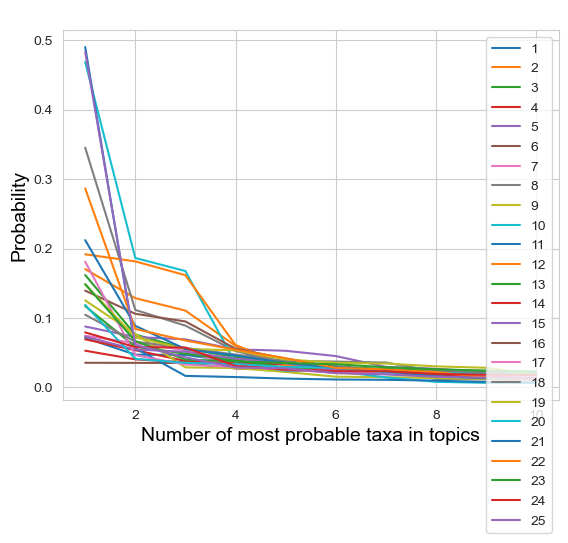

In [14]:
#print top 10 most probable taxa in each topic
print("LDA probabilities")
for i in range(NTOPICS):
    topic_name = 'Topic ' + str(i+1)
    print(topic_name)
    print(df_norm[topic_name].sort_values(ascending = False)[0:10])
    print("----------------------")
    
fig = plt.figure()
for i in range(NTOPICS):
    label = str(i+1)
    topic_name = 'Topic ' + str(i+1)
    sorted_probs = []
    for i, j in df_norm[topic_name].sort_values(ascending = False)[0:10].items():
        sorted_probs.append(j)
    plt.plot(range(1, 11), sorted_probs, label=label)
    
plt.legend()
plt.xlabel('Number of most probable taxa in topics', fontsize=14, color='Black')
plt.ylabel('Probability', fontsize=14, color='Black')
plt.title(" ")
plt.show()

In [38]:
#print top 10 most amplified taxa in each topic
print("Relative amplification")
for i in range(NTOPICS):
    topic_name = 'Topic ' + str(i+1)
    print(topic_name)
    print(s[topic_name].sort_values(ascending = False)[0:10])
    print("----------------------")

Relative amplification
Topic 1
Chloroflexi__Ktedonobacteria__C0119__nan__nan__nan_                                            0.010529
Acidobacteriota__Blastocatellia__Blastocatellales__Blastocatellaceae__JGI_0001001-H03__nan_    0.008729
Bacteroidota__Bacteroidia__Cytophagales__Hymenobacteraceae__Hymenobacter__nan_                 0.008729
Proteobacteria__Gammaproteobacteria__nan__nan__nan__nan_                                       0.008729
Gemmatimonadota__Longimicrobia__Longimicrobiales__Longimicrobiaceae__YC-ZSS-LKJ147__nan__      0.008729
Armatimonadota__Chthonomonadetes__Chthonomonadales__Chthonomonadaceae__Chthonomonas__nan_      0.008369
Proteobacteria__Gammaproteobacteria__Xanthomonadales__Rhodanobacteraceae__nan__nan_            0.008369
Acidobacteriota__Blastocatellia__DS-100__nan__nan__nan_                                        0.008369
Gemmatimonadota__Gemmatimonadetes__Gemmatimonadales__Gemmatimonadaceae__nan__nan_              0.008369
Actinobacteriota__Actinobacteria_

Text(0.5, 0, 'Topic')

Text(0, 0.5, 'Abundance')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, '14'),
  Text(1, 0, '9'),
  Text(2, 0, '13'),
  Text(3, 0, '7'),
  Text(4, 0, '10'),
  Text(5, 0, '20'),
  Text(6, 0, '25'),
  Text(7, 0, '3'),
  Text(8, 0, '6'),
  Text(9, 0, '22'),
  Text(10, 0, '5'),
  Text(11, 0, '16'),
  Text(12, 0, '19'),
  Text(13, 0, '24'),
  Text(14, 0, '8'),
  Text(15, 0, '17'),
  Text(16, 0, '11'),
  Text(17, 0, '15'),
  Text(18, 0, '4'),
  Text(19, 0, '23'),
  Text(20, 0, '2'),
  Text(21, 0, '1'),
  Text(22, 0, '21'),
  Text(23, 0, '12'),
  Text(24, 0, '18')])

Text(-0.20046442396390474, -0.8699593632290971, '5')

Text(-0.9963656082662643, 0.9154502876758539, '7')

Text(-0.9999984691792893, -0.9630450647837319, '9')

Text(-0.5485977737039245, -0.36880613369972826, '10')

Text(-0.987866877155016, -0.6583672938607699, '13')

Text(-0.9982983554845437, 0.7859116001016824, '14')

Text(-0.7261276920306954, -0.6008017663023111, '17')

Text(0.9006519224268583, -1.0146992740471819, '1')

Text(0.9249586715998298, 0.7583797670801092, '2')

Text(0.9210582548732024, -0.9166327187069738, '3')

Text(1.0120181721564072, 0.9392042840011945, '4')

Text(0.9772230748407318, 0.8193195394508057, '6')

Text(0.5040313415229549, -0.2428612485865087, '8')

Text(0.978700083767978, -0.9594648732926777, '11')

Text(0.8111296478008168, -0.8718098684820025, '12')

Text(0.8489913462054133, 0.11600683765869291, '15')

Text(0.8457701035551292, 0.8506004507919154, '16')

Text(0.7845887248450297, -0.9957265996797908, '18')

Text(0.8837125367426133, 0.9303385458452701, '19')

Text(0.932603121790827, -0.8307631683949408, '20')

Text(0.8035084650039234, 1.0240228156787046, '21')

Text(0.6680520053944258, 0.9949500990346032, '22')

Text(0.8952105487587998, 1.0485199323218624, '23')

Text(0.983399761396887, -0.7179269488318518, '24')

Text(0.289601778930894, -0.4351508397109193, '25')

Text(0.5, 0, 'Generation: 0 vs 1')

Text(0, 0.5, 'Watering: Half vs Full')

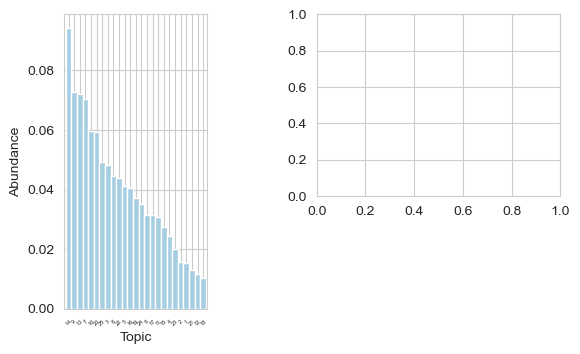

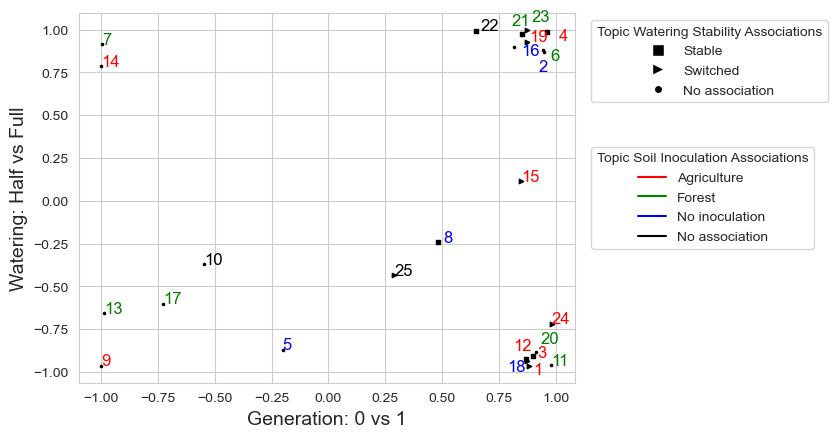

In [18]:
if tax_level == "Sequence":
    path = '../gitlab/data/5cv_all_sequence'
    sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = [str(i) for i in range(1, NTOPICS+1)] 
    source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["Generation"]), pd.DataFrame(df_gen0_gen1["Watering"])], axis=1)
    source_gen = source_gen.sort_index()
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Watering']

    fig = plt.figure()
    ax3 = plt.subplot2grid((10, 10), (0, 0),colspan=3, rowspan=8)
    test = sub_data
    test.columns = [str(i) for i in range(1, NTOPICS+1)] 
    test = pd.DataFrame(test.mean(axis=0))
    test.columns = ['Topic']
    test = test.sort_values('Topic',ascending=False)
    test = test.plot.bar(stacked=False, width = 1, ax=ax3, color=plt.cm.Paired(np.arange(len(df.T))), rot=0, legend=False)
    plt.xlabel('Topic')
    plt.ylabel('Abundance') 
    plt.xticks(rotation=45, fontsize=4)
    
    ax1 = plt.subplot2grid((10, 10), (0, 5), colspan=5, rowspan=5)
    w0 = potsvstopics[potsvstopics['Generation'] == 0]
    del w0['Generation']
    w1 = potsvstopics[potsvstopics['Generation'] == 1]
    del w1['Generation']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['G0', 'G1']
    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T
    #wt_df
    gwt_df = wt_df

    w_h = []
    w_f = []
    w_hi = []
    w_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['G0'][i] - wt_df['G1'][i]) < 1e-10):
            w_f.append(1 - wt_df['G0'][i]/wt_df['G1'][i])
            w_fi.append(wt_df.index[i])
        else:
            w_h.append(wt_df['G1'][i]/wt_df['G0'][i] - 1)
            w_hi.append(wt_df.index[i])


    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Generation']
    potsvstopics.columns = [str(i) for i in range(1, NTOPICS+1)] + ['Watering']#topic_names+['Watering']

    w0 = potsvstopics[potsvstopics['Watering'] == 0]
    del w0['Watering']
    w1 = potsvstopics[potsvstopics['Watering'] == 1]
    del w1['Watering']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['Half', 'Full']

    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T

    tw_h = []
    tw_f = []
    tw_hi = []
    tw_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['Half'][i] - wt_df['Full'][i]) < 1e-10):
            tw_f.append(1 - wt_df['Half'][i]/wt_df['Full'][i])
            tw_fi.append(wt_df.index[i])
        else:
            tw_h.append(wt_df['Full'][i]/wt_df['Half'][i] - 1)
            tw_hi.append(wt_df.index[i])

    sp_ = pd.DataFrame(
        {'Topic': w_hi + w_fi,
         'Generation': w_h + w_f
        })

    tr_ = pd.DataFrame(
        {'Topic': tw_hi + tw_fi,
         'Watering': tw_h + tw_f
        })

    sptr = sp_.merge(tr_, left_on='Topic', right_on='Topic', how = 'left')


    fig, ax = plt.subplots()

    x_c = sptr['Generation']
    y_c = sptr['Watering']
    types = sptr['Topic']

    for i,type in enumerate(types):
        x = x_c[i]
        y = y_c[i]

        if int(type) == 3 or int(type) == 4 or int(type) == 8 or int(type) == 12 or int(type) == 21 or int(type) == 22:
            plt.scatter(x, y, marker='s', color='black', s = 10)
        if int(type) == 1 or int(type) == 15 or int(type) == 18 or int(type) == 19 or int(type) == 23 or int(type) == 24 or int(type) == 25:
            plt.scatter(x, y, marker='>', color='black', s = 10)
        else:
            plt.scatter(x, y, marker='.', color='black', s = 10)

        #G1, FW   
        if int(type) == 2:
            plt.text(x-0.02, y-0.12, type, fontsize=12, color = 'blue')
        elif int(type) == 4:
            plt.text(x+0.05, y-0.05, type, fontsize=12, color = 'red')
        elif int(type) == 6:
            plt.text(x+0.03, y-0.05, type, fontsize=12, color = 'green')    
        elif int(type) == 16:
            plt.text(x+0.03, y-0.05, type, fontsize=12, color = 'blue')
        elif int(type) == 21:
            plt.text(x-0.05, y+0.05, type, fontsize=12, color = 'green')
        elif int(type) == 19:
            plt.text(x+0.01, y, type, fontsize=12, color = 'red')
        elif int(type) == 23:
            plt.text(x+0.02, y+0.05, type, fontsize=12, color = 'green')
        #G1, HW    
        elif int(type) == 20:
            plt.text(x+0.02, y+0.05, type, fontsize=12, color = 'green')  
        elif int(type) == 18:
            plt.text(x-0.09, y-0.06, type, fontsize=12, color = 'blue')  
        elif int(type) == 12:
            plt.text(x-0.06, y+0.05, type, fontsize=12, color = 'red')  
        elif int(type) == 3:
            plt.text(x+0.02, y-0.01, type, fontsize=12, color = 'red')  
        elif int(type) == 1:
            plt.text(x+0.02, y-0.05, type, fontsize=12, color = 'red')
        #all other
        elif int(type) == 7:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 14:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 22:
            plt.text(x+0.02, y, type, fontsize=12, color = 'black')
        elif int(type) == 15:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 8:
            plt.text(x+0.02, y, type, fontsize=12, color = 'blue')
        elif int(type) == 10:
            plt.text(x, y, type, fontsize=12, color = 'black')
        elif int(type) == 24:
            plt.text(x, y, type, fontsize=12, color = 'red')
        elif int(type) == 25:
            plt.text(x, y, type, fontsize=12, color = 'black')
        elif int(type) == 11:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 5:
            plt.text(x, y, type, fontsize=12, color = 'blue')
        elif int(type) == 13:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 17:
            plt.text(x, y, type, fontsize=12, color = 'green')
        elif int(type) == 9:
            plt.text(x, y, type, fontsize=12, color = 'red')


    legend_elements1 = [Line2D([0], [0], marker='s', color = 'white', label='Stable', markersize=8, markerfacecolor='black'),
                       Line2D([0], [0], marker='>', color = 'white', label='Switched',
                               markerfacecolor='black', markersize=8),
                        Line2D([0], [0], marker='.', color = 'white', label='No association',
                               markerfacecolor='black', markersize=12)]

    legend_elements2 = [Line2D([0], [0], color = 'red', label='Agriculture',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'green', label='Forest',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'blue', label='No inoculation',
                              markerfacecolor='black', markersize=10),
                       Line2D([0], [0], color = 'black', label='No association',
                              markerfacecolor='black', markersize=10)]

    leg1 = ax.legend(handles=legend_elements1, loc = 'center left', bbox_to_anchor = (1.02, 0.87), ncol = 1, title = 'Topic Watering Stability Associations')
    leg2 = ax.legend(handles=legend_elements2, loc = 'center left', bbox_to_anchor = (1.02, 0.5), ncol = 1, title = 'Topic Soil Inoculation Associations')
    ax.add_artist(leg1)

    plt.xlabel('Generation: 0 vs 1', fontsize = 14);
    plt.ylabel('Watering: Half vs Full', fontsize = 14);
    #plt.savefig('./upd_images/seq_1.eps', format='eps', bbox_inches='tight')
    plt.show();
    
else:
    sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = [str(i) for i in range(1, NTOPICS+1)] #topic_names
    source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["Generation"]), pd.DataFrame(df_gen0_gen1["Watering"])], axis=1)
    source_gen = source_gen.sort_index()
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Watering']


    fig = plt.figure()
    ax3 = plt.subplot2grid((10, 10), (0, 0),colspan=3, rowspan=8)
    test = sub_data
    test.columns = [str(i) for i in range(1, NTOPICS+1)] 
    test = pd.DataFrame(test.mean(axis=0))
    test.columns = ['Topic']
    test = test.sort_values('Topic',ascending=False)
    test = test.plot.bar(stacked=False, width = 1, ax=ax3, color=plt.cm.Paired(np.arange(len(df.T))), rot=0, legend=False)
    plt.xlabel('Topic')
    plt.ylabel('Abundance') 
    plt.xticks(rotation=45, fontsize=8)

    
    ax1 = plt.subplot2grid((10, 10), (0, 5), colspan=5, rowspan=5)
    w0 = potsvstopics[potsvstopics['Generation'] == 0]
    del w0['Generation']
    w1 = potsvstopics[potsvstopics['Generation'] == 1]
    del w1['Generation']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['G0', 'G1']
    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T
    gwt_df = wt_df

    w_h = []
    w_f = []
    w_hi = []
    w_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['G0'][i] - wt_df['G1'][i]) < 1e-10):
            w_f.append(1 - wt_df['G0'][i]/wt_df['G1'][i])
            w_fi.append(wt_df.index[i])
        else:
            w_h.append(wt_df['G1'][i]/wt_df['G0'][i] - 1)
            w_hi.append(wt_df.index[i])


    ax1.set_xlim(-10,10)
    ax1.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax1.hlines(y, xmin, xmax)
    ax1.vlines(xmin, y - height / 2., y + height / 2.)
    ax1.vlines(xmax, y - height / 2., y + height / 2.)

    ax1.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(w_h)):
        ax1.plot(w_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(w_f)):
        ax1.plot(w_f[i]*10, y, 'bo', ms = 8, mfc = 'b')


    for i in range(len(w_hi)):
        ax1.annotate(w_hi[i], (w_h[i]*10,y), xytext = (w_h[i]*10 + 2.5, y + 0.7),  
                  rotation = 45, ha="right")


    for i in range(len(w_fi)):   
        ax1.annotate(w_fi[i], (w_f[i]*10,y), xytext = (w_f[i]*10 + 2.5, y + 0.7),  
                      rotation = 45, ha="right")


    ax1.text(xmin - 0.1, y, 'G0', horizontalalignment='right')
    ax1.text(xmax + 0.1, y, 'G1', horizontalalignment='left')
    ax1.axis('off')      

    ax1.set_xlim(-10,10)
    ax1.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax1.hlines(y, xmin, xmax)
    ax1.vlines(xmin, y - height / 2., y + height / 2.)
    ax1.vlines(xmax, y - height / 2., y + height / 2.)

    ax1.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(w_h)):
        ax1.plot(w_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(w_f)):
        ax1.plot(w_f[i]*10, y, 'bo', ms = 8, mfc = 'b')

    ax1.text(xmin - 0.1, y, 'G0', horizontalalignment='right')
    ax1.text(xmax + 0.1, y, 'G1', horizontalalignment='left')
    ax1.axis('off')



    ax2 = plt.subplot2grid((10, 10), (5, 5), colspan=5, rowspan=5)
    potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
    del potsvstopics['ID']
    del potsvstopics['Generation']
    potsvstopics.columns = [str(i) for i in range(1, NTOPICS+1)] + ['Watering']#topic_names+['Watering']

    w0 = potsvstopics[potsvstopics['Watering'] == 0]
    del w0['Watering']
    w1 = potsvstopics[potsvstopics['Watering'] == 1]
    del w1['Watering']

    wt_df = pd.concat([pd.DataFrame(w0.sum(axis = 0)/np.sum(w0.sum(axis = 0))), pd.DataFrame(w1.sum(axis = 0)/np.sum(w1.sum(axis = 0)))], axis = 1)
    wt_df.columns = ['Half', 'Full']

    t = wt_df.T
    t = t.div(t.sum())
    wt_df = t.T

    tw_h = []
    tw_f = []
    tw_hi = []
    tw_fi = []
    for i in range(wt_df.shape[0]):
        if ((wt_df['Half'][i] - wt_df['Full'][i]) < 1e-10):
            tw_f.append(1 - wt_df['Half'][i]/wt_df['Full'][i])
            tw_fi.append(wt_df.index[i])
        else:
            tw_h.append(wt_df['Full'][i]/wt_df['Half'][i] - 1)
            tw_hi.append(wt_df.index[i])


    ax2.set_xlim(-10,10)
    ax2.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax2.hlines(y, xmin, xmax)
    ax2.vlines(xmin, y - height / 2., y + height / 2.)
    ax2.vlines(xmax, y - height / 2., y + height / 2.)

    ax2.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(tw_h)):
        ax2.plot(tw_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(tw_f)):
        ax2.plot(tw_f[i]*10, y, 'bo', ms = 8, mfc = 'b')


    for i in range(len(tw_hi)):
        ax2.annotate(tw_hi[i], (tw_h[i]*10,y), xytext = (tw_h[i]*10 + 2.5, y + 0.7),  
                  rotation = 45, ha="right")

    for i in range(len(tw_fi)):   
        ax2.annotate(tw_fi[i], (tw_f[i]*10,y), xytext = (tw_f[i]*10 + 2.5, y + 0.7),  
                      rotation = 45, ha="right")


    ax2.text(xmin - 0.1, y, 'Half', horizontalalignment='right')
    ax2.text(xmax + 0.1, y, 'Full', horizontalalignment='left')
    ax2.axis('off')      

    ax2.set_xlim(-10,10)
    ax2.set_ylim(0,10)

    xmin = -10
    xmax = 10
    y = 5
    height = 1

    ax2.hlines(y, xmin, xmax)
    ax2.vlines(xmin, y - height / 2., y + height / 2.)
    ax2.vlines(xmax, y - height / 2., y + height / 2.)

    ax2.vlines(0, y - height / 2., y + height / 2.)
    for i in range(len(tw_h)):
        ax2.plot(tw_h[i]*10, y, 'ro', ms = 8, mfc = 'r')
    for i in range(len(tw_f)):
        ax2.plot(tw_f[i]*10, y, 'bo', ms = 8, mfc = 'b')



    ax2.text(xmin - 0.1, y, 'Half', horizontalalignment='right')
    ax2.text(xmax + 0.1, y, 'Full', horizontalalignment='left')
    ax2.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(top=0.6, left=-0.3)
    plt.show();


    sp_ = pd.DataFrame(
        {'Topic': w_hi + w_fi,
         'Generation': w_h + w_f
        })

    tr_ = pd.DataFrame(
        {'Topic': tw_hi + tw_fi,
         'Watering': tw_h + tw_f
        })

    sptr = sp_.merge(tr_, left_on='Topic', right_on='Topic', how = 'left')


    x_c = sptr['Generation']
    y_c = sptr['Watering']
    types = sptr['Topic']
    for i,type in enumerate(types):
        x = x_c[i]
        y = y_c[i]
        plt.scatter(x, y, marker='.', color='black')
        plt.text(x+0.01, y+0.01, type, fontsize=12)

    plt.xlabel('Generation: 0 vs 1');
    plt.ylabel('Watering: Half vs Full');
    #plt.savefig('./upd_images/plot_2d_' + str(tax_level) + '.eps', format='eps', bbox_inches='tight')
    plt.show();

In [20]:
wt_df
wt_df['Half']/wt_df['Full']
wt_df['Full']/wt_df['Half']
gwt_df

Half      Full
1   0.965903  0.034097
2   0.108433  0.891567
3   0.914606  0.085394
4   0.010680  0.989320
5   0.884924  0.115076
6   0.115577  0.884423
7   0.077958  0.922042
8   0.569107  0.430893
9   0.964362  0.035638
10  0.613048  0.386952
11  0.961044  0.038956
12  0.927480  0.072520
13  0.745360  0.254640
14  0.176337  0.823663
15  0.469213  0.530787
16  0.090413  0.909587
17  0.714695  0.285305
18  0.939608  0.060392
19  0.065125  0.934875
20  0.893466  0.106534
21  0.025319  0.974681
22  0.005025  0.994975
23  0.001478  0.998522
24  0.779987  0.220013
25  0.639039  0.360961

1     28.328029
2      0.121620
3     10.710390
4      0.010796
5      7.689904
6      0.130680
7      0.084550
8      1.320762
9     27.059985
10     1.584299
11    24.669961
12    12.789338
13     2.927120
14     0.214088
15     0.883993
16     0.099400
17     2.505021
18    15.558536
19     0.069661
20     8.386670
21     0.025977
22     0.005050
23     0.001480
24     3.545181
25     1.770384
dtype: float64

1       0.035301
2       8.222316
3       0.093367
4      92.629336
5       0.130041
6       7.652253
7      11.827361
8       0.757139
9       0.036955
10      0.631194
11      0.040535
12      0.078190
13      0.341633
14      4.670968
15      1.131230
16     10.060408
17      0.399198
18      0.064273
19     14.355141
20      0.119237
21     38.495319
22    198.023685
23    675.644779
24      0.282073
25      0.564849
dtype: float64

G0        G1
1   0.106623  0.893377
2   0.052170  0.947830
3   0.090034  0.909966
4   0.036592  0.963408
5   0.555699  0.444301
6   0.050131  0.949869
7   0.996379  0.003621
8   0.340356  0.659644
9   0.999998  0.000002
10  0.688989  0.311011
11  0.020856  0.979144
12  0.114159  0.885841
13  0.988012  0.011988
14  0.998301  0.001699
15  0.131197  0.868803
16  0.155569  0.844431
17  0.785008  0.214992
18  0.111436  0.888564
19  0.112127  0.887873
20  0.080373  0.919627
21  0.127774  0.872226
22  0.260327  0.739673
23  0.110945  0.889055
24  0.016329  0.983671
25  0.415341  0.584659

In [21]:
#ternary plots, association with soil type and stability of water treatment
sub_data = pd.read_csv(path + '/doc-topic_' + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
sub_data.columns = topic_names
source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["SoilSource"]), pd.DataFrame(df_gen0_gen1["WateringStability"])], axis=1)
source_gen = source_gen.sort_index()
potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
del potsvstopics['ID']
del potsvstopics['WateringStability']


s0 = potsvstopics[potsvstopics['SoilSource'] == 0]
del s0['SoilSource']
s1 = potsvstopics[potsvstopics['SoilSource'] == 1]
del s1['SoilSource']
s2 = potsvstopics[potsvstopics['SoilSource'] == 2]
del s2['SoilSource']


st_df = pd.concat([pd.DataFrame(s0.sum(axis = 0)/np.sum(s0.sum(axis = 0))), pd.DataFrame(s1.sum(axis = 0)/np.sum(s1.sum(axis = 0))), pd.DataFrame(s2.sum(axis = 0)/np.sum(s2.sum(axis = 0)))], axis = 1)
st_df.columns = ['AG', 'FR', 'None'] 
t = st_df.T
t = t.div(t.sum())
t = t.T
c = t

c.loc[:, 'None'].sort_values(ascending = False)

sns.set_style("whitegrid")
c['Topic'] = range(1,NTOPICS+1)
c.columns = ['AG', 'FR', 'None', 'Topic']
color_discrete_map={"CustomColor": 'red'}
fig = px.scatter_ternary(c, a="AG", b="FR", c="None", size_max=15, text="Topic")#, color="Abundance", color_continuous_scale='RdYlBu_r')#, title = "Colored by the topic abundance")
fig = fig.update(layout=dict(title=dict(x=0.5)))
fig = fig.update_coloraxes(colorbar_title_side="bottom")
fig = fig.update_traces(textposition='bottom center', textfont=dict(size=12), selector=dict(type='scatterternary'), marker=dict(color='lightblue'))
#fig.write_image("./upd_images/plot_ternary_" + str(tax_level) + '.eps')
fig.show()



sub_data = pd.read_csv(path + "/doc-topic_" + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
sub_data.columns = topic_names
source_gen = pd.concat([pd.DataFrame(df_gen0_gen1["SoilSource"]), pd.DataFrame(df_gen0_gen1["WateringStability"])], axis=1)
source_gen = source_gen.sort_index()
potsvstopics = pd.concat([sub_data, source_gen.reset_index()], axis=1)
del potsvstopics['ID']
del potsvstopics['SoilSource']


ws0 = potsvstopics[potsvstopics['WateringStability'] == 0]
del ws0['WateringStability']
ws1 = potsvstopics[potsvstopics['WateringStability'] == 1]
del ws1['WateringStability']
ws2 = potsvstopics[potsvstopics['WateringStability'] == 2]
del ws2['WateringStability']


ws_df = pd.concat([pd.DataFrame(ws0.sum(axis = 0)/np.sum(ws0.sum(axis = 0))), pd.DataFrame(ws1.sum(axis = 0)/np.sum(ws1.sum(axis = 0))), pd.DataFrame(ws2.sum(axis = 0)/np.sum(ws2.sum(axis = 0)))], axis = 1)
ws_df.columns = ['Gen 0', 'Stable', 'Switched']


t = ws_df.T
t = t.div(t.sum())
t = t.T
c = t

c.loc[:, 'Gen 0'].sort_values(ascending = False)
c.loc[:, 'Stable'].sort_values(ascending = False)
c.loc[:, 'Switched'].sort_values(ascending = False)

sns.set_style("whitegrid")   
c['Topic'] = range(1, NTOPICS + 1)
c.columns = ["G0", "ST", "SW", 'Topic']
color_discrete_map={"CustomColor": 'red'}
#fig = plt.subplots(figsize=(10,10))
fig = px.scatter_ternary(c, a="G0", b="ST", c="SW", size_max=15, text="Topic")#, color="Abundance", color_continuous_scale='RdYlBu_r')#, title = "Colored by the topic abundance")
fig = fig.update(layout=dict(title=dict(x=0.5)))
fig = fig.update_coloraxes(colorbar_title_side="bottom")
fig = fig.update_traces(textposition='bottom center', textfont_size=12, selector=dict(type='scatterternary'), marker=dict(color='lightblue'))
#fig.write_image("./upd_images/plot_ternary2_" + str(tax_level) + '.eps')
fig.show()


Topic 18    0.955360
Topic 5     0.937687
Topic 2     0.929503
Topic 8     0.864238
Topic 16    0.641576
Topic 25    0.449464
Topic 10    0.214172
Topic 14    0.161896
Topic 9     0.141754
Topic 19    0.069067
Topic 17    0.058109
Topic 21    0.029346
Topic 22    0.004488
Topic 12    0.000931
Topic 11    0.000671
Topic 24    0.000019
Topic 13    0.000018
Topic 23    0.000007
Topic 1     0.000006
Topic 3     0.000005
Topic 6     0.000005
Topic 4     0.000005
Topic 15    0.000004
Topic 20    0.000004
Topic 7     0.000002
Name: None, dtype: float64

Topic 9     0.999997
Topic 14    0.996608
Topic 7     0.992784
Topic 13    0.976309
Topic 17    0.646101
Topic 10    0.525540
Topic 5     0.384753
Topic 25    0.262101
Topic 8     0.205078
Topic 22    0.149641
Topic 16    0.084345
Topic 15    0.070204
Topic 21    0.068247
Topic 12    0.060535
Topic 19    0.059393
Topic 18    0.059006
Topic 23    0.058730
Topic 1     0.056314
Topic 3     0.047139
Topic 20    0.041869
Topic 2     0.026784
Topic 6     0.025710
Topic 4     0.018637
Topic 11    0.010538
Topic 24    0.008232
Name: Gen 0, dtype: float64

Topic 4     0.966060
Topic 3     0.842347
Topic 12    0.832049
Topic 22    0.784116
Topic 21    0.783181
Topic 11    0.620816
Topic 6     0.612933
Topic 8     0.590236
Topic 20    0.571477
Topic 2     0.355749
Topic 16    0.316419
Topic 5     0.313264
Topic 1     0.300023
Topic 19    0.186980
Topic 25    0.180656
Topic 24    0.172385
Topic 10    0.150960
Topic 23    0.063079
Topic 18    0.027739
Topic 13    0.012054
Topic 7     0.007215
Topic 15    0.003522
Topic 14    0.001211
Topic 17    0.000033
Topic 9     0.000001
Name: Stable, dtype: float64

Topic 15    0.926275
Topic 18    0.913256
Topic 23    0.878191
Topic 24    0.819383
Topic 19    0.753627
Topic 1     0.643664
Topic 2     0.617468
Topic 16    0.599236
Topic 25    0.557243
Topic 20    0.386654
Topic 11    0.368647
Topic 6     0.361357
Topic 17    0.353866
Topic 10    0.323500
Topic 5     0.301983
Topic 8     0.204687
Topic 21    0.148572
Topic 3     0.110514
Topic 12    0.107416
Topic 22    0.066243
Topic 4     0.015303
Topic 13    0.011637
Topic 14    0.002181
Topic 9     0.000002
Topic 7     0.000001
Name: Switched, dtype: float64

In [24]:
#Spearman's rank correlation with plant traits
ntopics = NTOPICS
response_list = ['WUEi', "Amax", 'Cond', 'SCP_Curve', 'Stem_Diam', 'DroughtTime', 'RootDry_g', "Height_cm", "LWC", "LMA"]
store_cor = []
store_pval = []
topic_list = topic_names
alpha = 0.05

if tax_level == 'Sequence':
    sub_data = pd.read_csv('../gitlab/data/5cv_all_sequence' + "/doc-topic_" + str(NTOPICS) + '.dat', sep='\s+', header=None).iloc[:, np.r_[2:NTOPICS+2]]
    sub_data.columns = topic_names
    for i in response_list:
        store_cor.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[0])
        store_pval.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[1])

    store_pval = [item for sublist in store_pval for item in sublist]
    store_cor = [item for sublist in store_cor for item in sublist]
    store_names = [item for item in response_list for i in range(ntopics)]
    store_topics = topic_list*len(response_list)
    df_p = pd.DataFrame(
        {'topic': store_topics,
         'response': store_names,   
         'correlation': store_cor,
         'p-value': store_pval
        })
    cor_alpha = len(df_p.sort_values("p-value"))
    df_p = df_p.sort_values("p-value", ascending=True).reset_index()
    save_ix = []
    for i in range(len(df_p)):
        if (df_p['p-value'][i] <= alpha/cor_alpha):
            cor_alpha -= 1
            save_ix.append(df_p.index[i])
    df_p = df_p.iloc[save_ix, 1:5]
    print(df_p.to_latex(index=False))  
else:
    response_list = ['Water use efficiency', "Maximum rate of photosynthesis", 'Stomatal conductance', 'Stomatal closure point', 'Stem diameter', 'Drought time', 'Root biomass', "Stem height", "% Leaf water content", "Leaf mass per area"]
    for i in response_list:
        store_cor.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[0])
        store_pval.append(spearmanr_topic_vs_trait_holmbonf(i, ntopics, 0.05, len(response_list)*ntopics)[1])
    store_pval = [item for sublist in store_pval for item in sublist]
    store_cor = [item for sublist in store_cor for item in sublist]
    store_names = [item for item in response_list for i in range(ntopics)]
    store_topics = topic_list*len(response_list)
    df_p = pd.DataFrame(
        {'topic': store_topics,
         'response': store_names,   
         'correlation': store_cor,
         'p-value': store_pval
        })
    cor_alpha = len(df_p.sort_values("p-value"))
    df_p = df_p.sort_values("p-value", ascending=True).reset_index()
    save_ix = []
    for i in range(len(df_p)):
        if (df_p['p-value'][i] <= alpha/cor_alpha):
            cor_alpha -= 1
            #print(i, alpha/cor_alpha, df_p['topic'][i], df_p['response'][i], df_p['correlation'][i], df_p['p-value'][i])
            save_ix.append(df_p.index[i])

    df_p = df_p.iloc[save_ix, 1:5]
    print(df_p.to_latex(index=False))  



\begin{tabular}{llrr}
\toprule
   topic &  response &  correlation &      p-value \\
\midrule
 Topic 9 & Height\_cm &    -0.622323 & 4.186909e-14 \\
 Topic 7 & Height\_cm &    -0.610016 & 1.784144e-13 \\
Topic 14 & Height\_cm &    -0.574516 & 8.380912e-12 \\
Topic 13 & Height\_cm &    -0.568971 & 1.467622e-11 \\
 Topic 9 & RootDry\_g &     0.565924 & 1.988042e-11 \\
Topic 13 & RootDry\_g &     0.535145 & 3.610858e-10 \\
 Topic 7 & RootDry\_g &     0.504180 & 5.043032e-09 \\
Topic 14 & RootDry\_g &     0.496297 & 9.471054e-09 \\
Topic 17 & Height\_cm &    -0.479713 & 3.389113e-08 \\
 Topic 1 & Height\_cm &    -0.464991 & 9.944427e-08 \\
 Topic 9 & Stem\_Diam &     0.430547 & 1.021565e-06 \\
Topic 23 & RootDry\_g &     0.429148 & 1.116978e-06 \\
Topic 17 & RootDry\_g &     0.423508 & 1.594640e-06 \\
Topic 24 & Height\_cm &    -0.411778 & 3.276476e-06 \\
Topic 13 & Stem\_Diam &     0.407525 & 4.225824e-06 \\
Topic 15 & Height\_cm &    -0.407223 & 4.302262e-06 \\
 Topic 4 & Height\_cm &   